This notebook presents exploratory data analysis of the critical illness coverage dataset.

# Project set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [2]:
sns.set()

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3}'.format)

In [4]:
pd.__version__

'2.2.3'

# Load Dataset

In [5]:
df = pd.read_csv('../DATA/CI_CVGS.csv', low_memory=False)

In [6]:
#Some columns of the dataset are private
display_cols = ['CLAIM', 'START_AGE', 'TENURE', 'MATURITY_AGE', 'TIME_TO_MATURE', 
                'SEX_CD', 'SUM_INSURED', 'SMOKER', 'MARITAL_STATUS', 'INCOME', 'YEARS_EMPLOYED']

In [7]:
df.loc[:, display_cols].head()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SEX_CD,SUM_INSURED,SMOKER,MARITAL_STATUS,INCOME,YEARS_EMPLOYED
0,0,42,149,70,10078,M,1e+05,0,UNKNOWN,5000,13
1,0,36,303,65,10289,M,1e+05,0,UNKNOWN,12000,1
2,0,28,918,65,12596,F,1e+06,0,UNKNOWN,0,0
3,0,33,3291,65,8397,M,2.5e+05,0,MARRIED,1666,6
4,0,40,728,65,8403,F,2.5e+05,0,MARRIED,8333,10


In [8]:
print('Size of dataset: ', df.shape)
print('Number of unique clients: ', df['MDM_ID'].nunique())
print('Number of CI claims observed:', df['CLAIM'].sum())

Size of dataset:  (110402, 18)
Number of unique clients:  89510
Number of CI claims observed: 2135


In [9]:
#Convert columns to datetime format
cols = ['START_DT', 'END_DT', 'MATURITY_DT', 'DOB']
for col in cols:
    df.loc[:, col] = pd.to_datetime(df[col])

In [10]:
df.loc[:, 'SMOKER'] = df.SMOKER.replace(to_replace=-1, value=1)

In [11]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
df = df.convert_dtypes(convert_floating=False, convert_integer=False)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110402 entries, 0 to 110401
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   MDM_ID          110402 non-null  int64         
 1   CLI_ID          110402 non-null  int64         
 2   CVG_ID          110402 non-null  string        
 3   CLAIM           110402 non-null  int64         
 4   START_AGE       110402 non-null  int64         
 5   TENURE          110402 non-null  int64         
 6   START_DT        110402 non-null  datetime64[ns]
 7   END_DT          110402 non-null  datetime64[ns]
 8   MATURITY_AGE    110402 non-null  int64         
 9   MATURITY_DT     110402 non-null  datetime64[ns]
 10  TIME_TO_MATURE  110402 non-null  int64         
 11  SEX_CD          110402 non-null  string        
 12  SUM_INSURED     110402 non-null  float64       
 13  SMOKER          110402 non-null  int64         
 14  MARITAL_STATUS  110402 non-null  str

In [13]:
df.loc[:, display_cols].describe()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SUM_INSURED,SMOKER,INCOME,YEARS_EMPLOYED
count,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05
mean,0.0193,32.2,1.96e+03,67.5,1.1e+04,2.01e+05,0.114,1.09e+04,6.49
std,0.138,8.89,2.2e+03,3.55,4.08e+03,2.07e+05,0.318,4.36e+04,7.24
min,0.0,14.0,21.0,64.0,0.0,2e+04,0.0,0.0,0.0
25%,0.0,25.0,4.17e+02,65.0,8.47e+03,1e+05,0.0,5e+03,1.0
50%,0.0,31.0,1e+03,65.0,1.15e+04,1.25e+05,0.0,7.5e+03,4.0
75%,0.0,38.0,2.79e+03,70.0,1.39e+04,2.3e+05,0.0,1.2e+04,10.0
max,1.0,65.0,1.31e+04,81.0,2.33e+04,8e+06,1.0,7e+06,82.0


In [14]:
df.loc[:, 'LAST_AGE'] = df.apply(lambda x: x['START_AGE'] + relativedelta(x['END_DT'], x['START_DT']).years , axis=1)

## Claimants Data
Extract claimants for analysis

In [15]:
claimants = df.query('CLAIM == 1').copy()

# Exploratory Data Analysis

## Critical Illness Claims
The target variable, critical illness claim, is a rare event with only a rate of 1.93%.

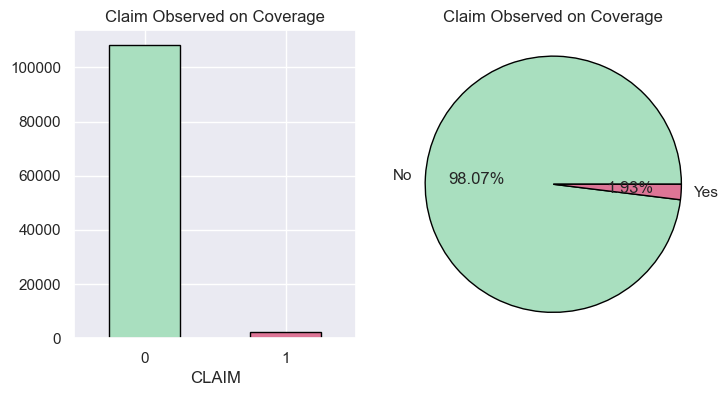

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
colors = ['#A9DFBF', '#DD7596']
data = df['CLAIM'].value_counts()
data.plot.bar(grid=True, ax=ax1, title='Claim Observed on Coverage', rot=0, color=colors, edgecolor='black')

colors = ['#A9DFBF', '#DD7596']
ax2.pie(df['CLAIM'].value_counts(), labels=['No', 'Yes'], 
        autopct='%1.2f%%', colors=colors, wedgeprops={'linewidth':1, 'edgecolor':'black'})
ax2.axis('equal')
ax2.set_title('Claim Observed on Coverage')

plt.show()

## Age at claim
Claimants are mostly between 38 - 60.

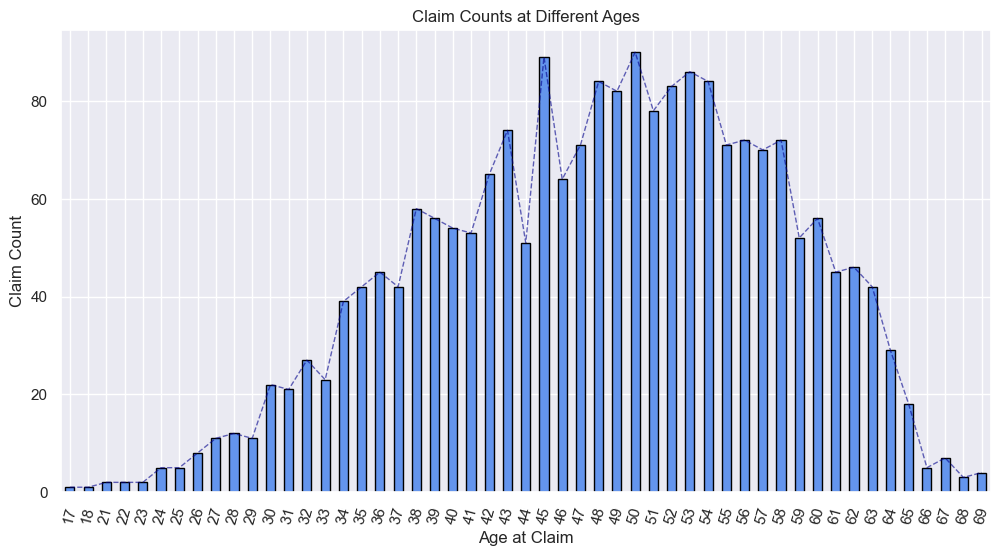

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
data = df.query('CLAIM == 1').groupby('LAST_AGE').agg(claim_count=('CLAIM', 'size'))
data.plot(kind='line', ax=ax, use_index=False, c='darkblue', alpha=0.6, linestyle='--', lw=1, legend=False)
data.plot(kind='bar', ax=ax, color='#6495ED', edgecolor='black', legend=False, rot=75, 
          ylabel='Claim Count', xlabel='Age at Claim', title='Claim Counts at Different Ages')
plt.show()

## Year of claim
The popularity of this policy has risen with time, but might be stagnating.

In [18]:
df.loc[:, 'END_YR'] = df['END_DT'].dt.year
df.loc[:, 'START_YR'] = df['START_DT'].dt.year

<Axes: title={'center': 'Claim Counts Across Years'}, xlabel='Year of Claim', ylabel='Claim Count'>

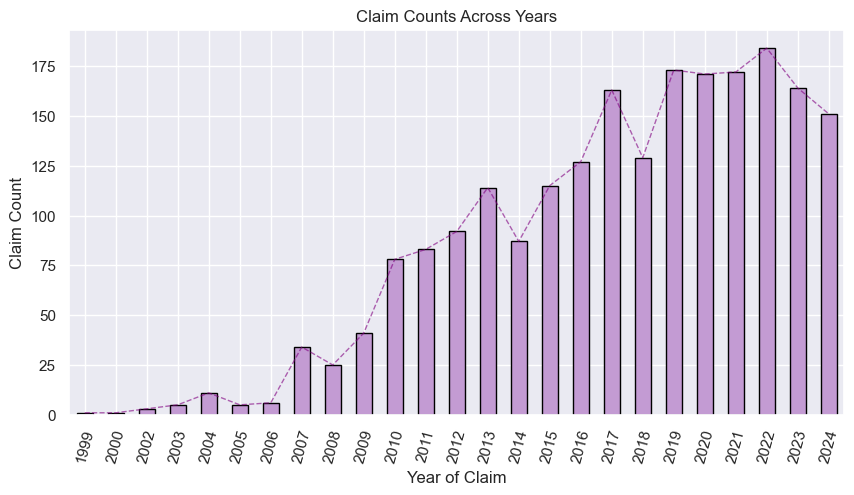

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
data = df.query('CLAIM == 1').groupby('END_YR').agg(claim_count=('CLAIM', 'size'))
data.plot(kind='line', ax=ax, use_index=False, c='purple', alpha=0.6, linestyle='--', lw=1, legend=False)
data.plot(kind='bar', ax=ax, color='#C39BD3', edgecolor='black', legend=False, rot=75,
          ylabel='Claim Count', xlabel='Year of Claim', title='Claim Counts Across Years')

## Product tenure and maturity time
Clients who claim tend to maintain their coverages for longer periods of time.

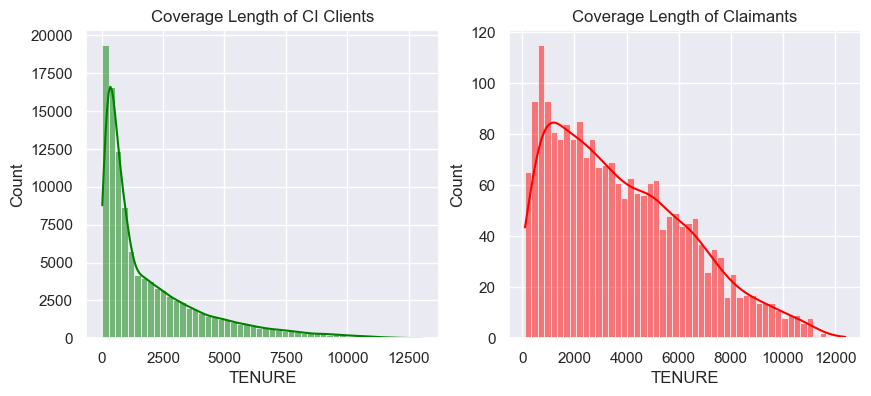

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(data=df['TENURE'], ax=ax1, kde=True, bins=50, color='green')
ax1.set_title('Coverage Length of CI Clients')
sns.histplot(data=claimants['TENURE'], ax=ax2, kde=True, bins=50, color='red')
ax2.set_title("Coverage Length of Claimants")
plt.show()

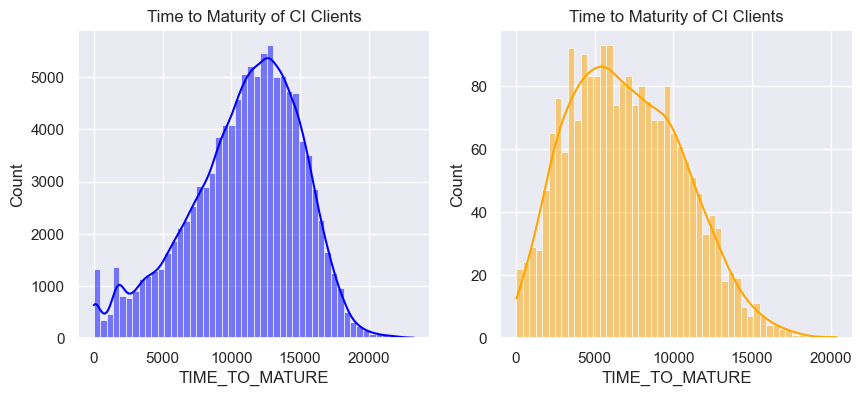

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(data=df['TIME_TO_MATURE'], ax=ax1, kde=True, bins=50, color='blue')
ax1.set_title('Time to Maturity of CI Clients')
sns.histplot(data=claimants['TIME_TO_MATURE'], ax=ax2, kde=True, bins=50, color='orange')
ax2.set_title("Time to Maturity of CI Clients")
plt.show()

## Sex
Sex seems to be equally distributed in both populations.

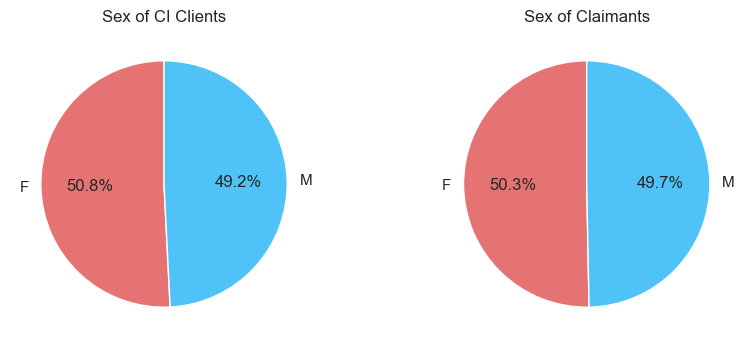

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
colors = ['#e57373', '#4fc3f7']
ax1.pie(df['SEX_CD'].value_counts(), labels=['F', 'M'], autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Sex of CI Clients')
ax2.pie(claimants['SEX_CD'].value_counts(), labels=['F', 'M'], autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sex of Claimants')
plt.show()

## Smoker
Surprisingly, there are fewer smokers among critical illness claimants.

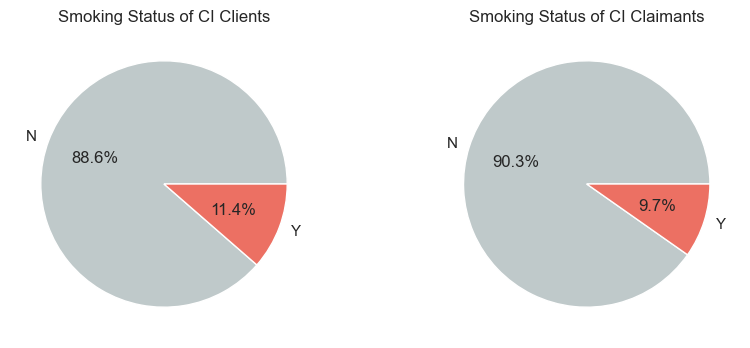

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
colors = ['#bfc9ca', '#EC7063']
ax1.pie(df['SMOKER'].value_counts(), labels=['N', 'Y'], autopct='%1.1f%%', colors=colors)
ax1.set_title('Smoking Status of CI Clients')
ax2.pie(claimants['SMOKER'].value_counts(), labels=['N', 'Y'], autopct='%1.1f%%', colors=colors)
ax2.set_title('Smoking Status of CI Claimants')
plt.show()

## Marital status
There are more claims from married claimants than single claimants.

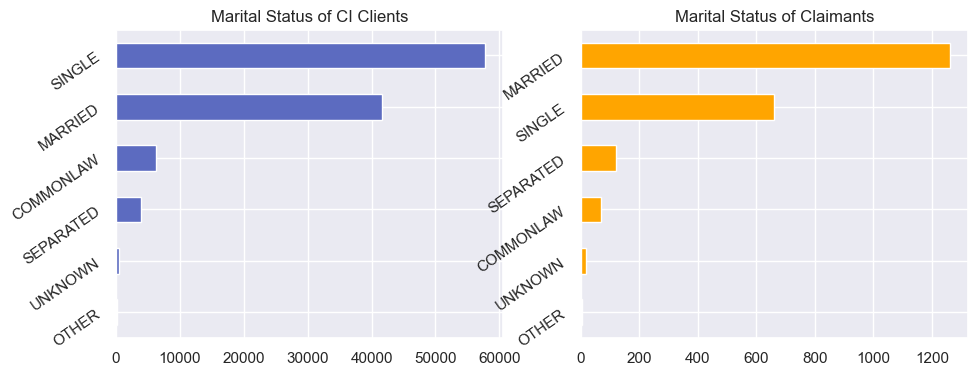

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
data = df['MARITAL_STATUS'].value_counts().sort_values()
data.plot.barh(grid=True, ax=ax1, title='Marital Status of CI Clients', ylabel='', rot=35, color='#5c6bc0')
data2 = claimants['MARITAL_STATUS'].value_counts().sort_values()
data2.plot.barh(grid=True, ax=ax2, title='Marital Status of Claimants', ylabel='', rot=35, color='orange')
plt.show()

## Income and Years of Employment
Claimants tend to have slightly higher incomes and years of employment on average.

In [25]:
df.loc[:, 'INCOME_CAP'] = df['INCOME'].copy()
df.loc[df['INCOME'] > 5e4, 'INCOME_CAP'] = 5e4

df.loc[:, 'YEARS_EMPLOYED_CAP'] = df['YEARS_EMPLOYED'].copy()
df.loc[df['YEARS_EMPLOYED'] > 40, 'YEARS_EMPLOYED_CAP'] = 40

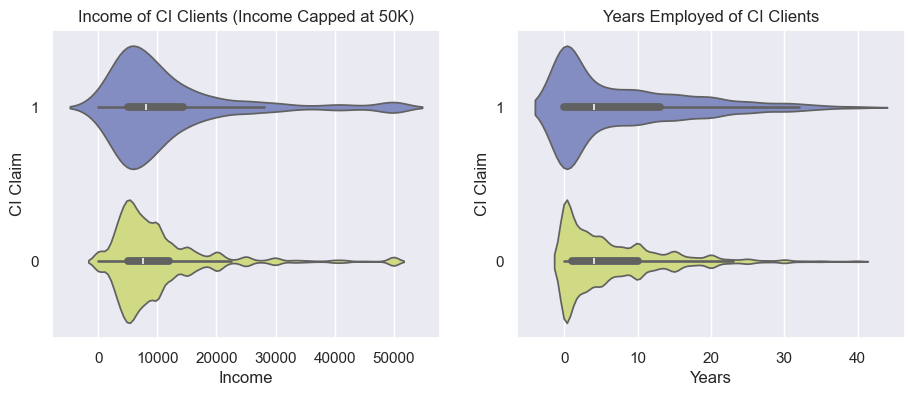

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
pal={0:'#dce775', 1:'#7986cb'}

sns.violinplot(data=df, y="CLAIM", order=[1,0], x="INCOME_CAP", hue="CLAIM", orient='h', ax=ax1, palette=pal)
ax1.set_title('Income of CI Clients (Income Capped at 50K)')
ax1.set_xlabel('Income')
ax1.set_ylabel('CI Claim')
ax1.get_legend().remove()

sns.violinplot(data=df, y="CLAIM", order=[1,0], x="YEARS_EMPLOYED_CAP", hue="CLAIM", orient='h', ax=ax2, palette=pal)
ax2.set_title('Years Employed of CI Clients')
ax2.set_xlabel('Years')
ax2.set_ylabel('CI Claim')
ax2.get_legend().remove()
plt.show()